In [1]:
import pandas as pd
from pandas import DataFrame, Series
import PyPDF2
from PyPDF2 import PdfFileReader
import math
import requests
import regex as re
import datetime
import matplotlib 
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import numpy as np
from datetime import datetime

In [2]:
plt.rcParams['font.size']=13

In [3]:
meeting = DataFrame(pd.read_csv("Board Committee Commission Meeting Data.csv"))
agendas = meeting['Agenda_Link']
notes = meeting['Minutes_Link']

In [4]:
for i in range(len(meeting)):
    new = re.sub(r"\s", "", meeting['Meeting_ID'][i])
    meeting['Meeting_ID'][i] = new

<ipython-input-4-77a6d85d7f34>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meeting['Meeting_ID'][i] = new


In [5]:
meeting['Duration_minutes'] = meeting['Duration'] #copy a column so that I have one to replace with the cell below

In [6]:
for i in range(len(meeting['Duration'])):
    time = re.split(':',meeting['Duration'][i])
    time = [int(x) for x in time]
    seconds = time[0]*60 + time[1] + time[2]/60
    meeting.iloc[i,10] = seconds

In [7]:
text_dict = {}
text_list = []
for x in meeting['Meeting_ID']:
    try:
        pdfFileObject = open('pdf_agendas/'+x+'.pdf','rb')
        pdfReader = PdfFileReader(pdfFileObject)
        pageObject = pdfReader.getPage(0)
        number_of_pages = pdfReader.getNumPages()
        txt = ''
    except Exception:
        text_list.append("N/A")
        continue
    for i in range(number_of_pages):
        pageObject = pdfReader.getPage(i)
        txt+= pageObject.extractText()
    text_dict[x] = txt
    text_list.append(txt)
meeting['text']=text_list





In [8]:
text_dict = {}
text_list = []
for x in meeting['Meeting_ID']:
    try:
        pdfFileObject = open('pdf_notes/'+x+'.pdf','rb')
        pdfReader = PdfFileReader(pdfFileObject)
        pageObject = pdfReader.getPage(0)
        number_of_pages = pdfReader.getNumPages()
        txt = ''
    except Exception:
        text_list.append("N/A")
        continue
    for i in range(number_of_pages):
        pageObject = pdfReader.getPage(i)
        txt+= pageObject.extractText()
    text_dict[x] = txt
    text_list.append(txt)
meeting['note_text']=text_list

Relationship between Duration and Participants

In [9]:
dates = []
starting = []
for i in meeting['Zoom_Meeting_Start_Time']:
    unformatted = i.split()[0]
    time = i.split()[1]
    datetime = datetime.strptime(unformatted , '%m/%d/%Y')
    time_start = datetime.strptime(time , '%H:%M')
    dates.append(datetime)
    starting.append(time_start)


In [10]:
day_of_week = [x.strftime("%A") for x in dates]
day_of_week_coded = [x.strftime("%w") for x in dates]
meeting['day_of_week']=day_of_week
meeting['day_of_week_coded']=day_of_week_coded

Time of Day and Starting Hour

In [11]:
meeting['starting_formatted']=[int(x.strftime("%H")) for x in starting]

In [12]:
import re
import pdfminer
from subprocess import check_output
from bs4 import BeautifulSoup
from collections import defaultdict

In [13]:
def find_near(x, y):
    for x_ in range(x-5, x+5):
        for y_ in range(y-5, y+5):
            if (x_, y_) in text:
                return text[(x_, y_)]
    return None

meeting_id = meeting['Meeting_ID']
agenda_items = []
overall_list = []
for i in meeting_id:
    agenda_file = "pdf_agendas/" + i +".pdf"
    try:
        s = check_output(["pdf2txt.py", "-t", "html", "-Y", "loose", agenda_file])
    except Exception:
        agenda_items.append("N/A")
        overall_list.append("N/A")
        continue
    page = BeautifulSoup(s)

    text = {} # key=(x,y), val=text

    for div in page.find_all("div"): #gets a list of different div tags 
        style = div.attrs.get("style", "") #attrs will tell you the positioning
        m1 = re.search("left:(\d+)px", style)
        m2 = re.search("top:(\d+)px", style)
        if m1 and m2:
            x, y = int(m1.group(1)), int(m2.group(1))#each parenthesis is a different group
            text[(x,y)] = div.get_text()

    agenda_dict = {}
    rand_str = ""

    for (x,y), t in text.items():
        
        # agenda items are roughly at x=170
        if 165 < x < 175:
            # agenda numbers are rougly at x=69, same y as text
            num = find_near(69, y)
            if num and re.match('[0-9]+',num) != None:
                agenda_num = int(re.match('[0-9]+',num).group(0))
                agenda_dict[agenda_num] = t
                rand_str+=t
    agenda_items.append(agenda_dict)
    overall_list.append(rand_str)
    

In [14]:
meeting['agenda_num'] = overall_list
agenda_amount = [len(x) for x in agenda_items]
meeting['agenda_amount'] = agenda_amount

**Committee**

In [15]:
committee = ['Common Council Executive Committee',
 'Common Council Executive Committee',
 'Finance Committee',
 'Common Council Executive Committee',
 'Plan Commission',
 'Transportation Commission',
 'Common Council Executive Committee',
 'Common Council Executive Committee',
 'Common Council Executive Committee',
 'Board of Public Works',
 'Alcohol License Review Committee',
 'Plan Commission',
 'Finance Committee',
 'Urban Design Commission',
 'Landmarks Commission',
 'MATPB',
 'Common Council Executive Committee',
 'Food Policy Council',
 'MATPB',
 'Plan Commission',
 'Finance Committee',
 'Transportation Commission',
 'Board of Park Commissioners',
 'Monona Terrace Community & Convention Center Board',
 'Common Council Executive Committee',
 'Plan Commission',
 'Task Force on Golf in Madison Parks',
 'Common Council Executive Committee',
 'Common Council Executive Committee',
 'Board of Public Works',
 'Alcohol License Review Committee',
 'Zoning Board of Appeals',
 'Common Council Executive Committee',
 'Urban Design Commission',
 'Alcohol License Review Committee',
 'Alcohol License Review Committee',
 'Room Tax Commission',
 'Landmarks Commission',
 'Common Council Executive Committee',
 'Common Council Executive Committee',
 'Board of Public Works',
 'Madison Food Policy Council',
 'Community Development Block Grant Committee',
 'Madison Public Library Board',
 'Plan Commission',
 'Equal Opportunities Commission',
 'Complete Count Committee',
 'Finance Committee',
 'Public Safety Review Committee',
 'Board of Park Commissioners',
 "President's Work Group on Council Communication Tools & Processes",
 'CDA Board',
 'Equal Opportunities Commission',
 'Common Council Executive Committee',
 'Transportation Policy and Planning Board',
 'Board of Building Code, Fire Code, Conveyance Code and Licensing Appeals',
 'Common Council Executive Committee',
 'Common Council Executive Committee',
 'Board of Public Works',
 'Economic Development Committee',
 'Alcohol License Review Committee',
 'MATPB',
 'Monona Terrace Community & Convention Center Board',
 'Monona Terrace Community & Convention Center Board',
 'PSRC',
 'Finance Committee',
 'PSRC',
 'Sustainable Madison Committee',
 'Water Utility Board',
 'MATPB',
 'Transportation Commission',
 'Community Services Committee',
 'Housing Strategy Committee',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'Common Council Executive Committee',
 'Monona Terrace Community & Convention Center Board',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'Plan Commission',
 'Equal Opportunities Commission',
 'Task Force on Golf in Madison Parks',
 'Monona Terrace Community & Convention Center Board',
 'Madison Food Policy Council',
 'Downtown Coordinating Committee',
 'Landlord and Tenant Issues Committee',
 'Madison Food Policy Council',
 'Urban Design Commission',
 'MATPB',
 'PSRC',
 'Body-Worn Camera Feasibility Review Committee',
 'Madison Public Library Board',
 'Affirmative Action Commission',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'Board of Building Code, Fire Code, Conveyance Code and Licensing Appeals',
 'Transportation Policy and Planning Board',
 'PSRC',
 'Room Tax Commission',
 'Madison Food Policy Council',
 'Madison Arts Commission',
 'Board of Public Works',
 'Public Safety Review Committee',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'Madison Food Policy Council',
 'Board of Park Commissioners',
 "President's Work Group on Council Communication Tools & Processes",
 'Community Development Authority Board',
 'Madison Public Library Board',
 'Equal Opportunities Commission',
 'Ad Hoc Task Force on the Structure of City Government (TFOGS) Final Report Implementation Work Group',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'Traffic Calming Subcommittee',
 'Landmarks Commission',
 'Plan Commission',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'City-Wide Violence Meeting',
 'Common Council Executive Committee',
 'Common Council Executive Committee',
 'PSRC',
 'Transportation Policy and Planning Board',
 'Alcohol License Review Committee',
 'Task Force on Golf in Madison Parks',
 'PSRC',
 "President's Work Group on Council Communication Tools & Processes",
 'Monona Terrace Community & Convention Center Board',
 'Monona Terrace Community & Convention Center Board',
 'CDBG Committee',
 'Traffic Calming Subcommittee',
 'Body-Worn Camera Feasibility Review Committee',
 'Finance Committee',
 'Board of Building Code, Fire Code, Conveyance Code and Licensing Appeals',
 'Common Council Executive Committee',
 'Common Council Executive Committee',
 'Personnel Board',
 'Board of Public Works',
 'Transportation Commission',
 "President's Work Group on Council Communication Tools & Processes",
 'Madison Food Policy Council',
 'Housing Strategy Committee',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'Task Force on Golf in Madison Parks',
 'Ad Hoc Task Force on the Structure of City Government (TFOGS) Final Report Implementation Work Group',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'Finance Committee',
 'Sustainable Madison Committee',
 'Plan Commission',
 'Water Utility Board',
 'Public Safety Review Committee',
 'Food Systems Recovery and Resilience Work Group',
 'Urban Design Commission',
 'Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight',
 'MLK Commission',
 'Public Safety Review Committee',
 'Plan Commission',
 'Body-Worn Camera Feasibility Review Committee',
 'Task Force on Golf in Madison Parks',
 'Deferred Compensation Committee']
meeting['Committee']=committee


In [16]:
abbr = {"City-Wide Violence Meeting":"CWVM",
        "Water Utility Board":"WUB",
        "Complete Count Committee":"Count Com.",
        "Madison Public Library Board":"MPLB",
        "Downtown Coordinating Committee":"DC Com.",
        "Madison Food Policy Council":"MFP Coun.",
        "Room Tax Commission":"RT Comm.",
        "Landlord and Tenant Issues Committee":"L&TI Com." ,
        'Personnel Board':"PB" ,
        "CDA Board":"CDAB",
        "Traffic Calming Subcommittee":"TC Subcom.",
        "Affirmative Action Commission":"AA Comm.",
        "Ad Hoc Task Force on the Structure of City Government (TFOGS) Final Report Implementation Work Group":"Ad Hoc W.G.",
        "Community Development Authority Board":"CDAB",
        "CDBG Committee":'CDBG Com.',
        "Board of Public Works":"BPW",
        "Board of Park Commissioners":"BP Comm.",
        'PSRC':"PSRC",
        "Alcohol License Review Committee":"ALR Com.",
        "Body-Worn Camera Feasibility Review Committee":"BWCFR Com.",
        "Finance Committee" :"Finance Com.",
        "Community Services Committee":"CS Com.",
        "MATPB":"MATPB",
        "Plan Commission":"Plan Comm.",
        "Zoning Board of Appeals":"ZBA",
        "Alder Workgroup to Develop Logistics and Operational Details for MPD Independent Civilian Oversight":'Alder W.G.',
        "Landmarks Commission":"Landmarks Comm.",
        "Public Safety Review Committee":"PSR Com.",
        "President's Work Group on Council Communication Tools & Processes":"CCTP W.G.",
        "Food Policy Council":"FPC",
        "Transportation Policy and Planning Board":"TPPB",
        "Community Development Block Grant Committee":"CDBGC",
        "Economic Development Committee":"ED Com.",
        "Task Force on Golf in Madison Parks":"TFGMP",
        "Transportation Commission":"Transportation Comm.",
        "Urban Design Commission":"UD Comm.",
        "Board of Building Code, Fire Code, Conveyance Code and Licensing Appeals":"BBFCL",
        "Monona Terrace Community & Convention Center Board":"MTCCCB",
        "Housing Strategy Committee":"HS Com.",
        "Deferred Compensation Committee":"DefComp Com.",
        "MLK Commission":"MLK Comm.",
        "Common Council Executive Committee":"CCE Com.",
        "Sustainable Madison Committee":"SM Com.",
        "Madison Arts Commission":"MA Comm.",
        "Equal Opportunities Commission":"EO Comm.",
        "Food Systems Recovery and Resilience Work Group":"FSRR W.G."}
abbreviated = []
for i in meeting['Committee']:
    abbreviated.append(abbr[i])
meeting['Abbreviations']=abbreviated

Alder List

In [17]:
alders=[
    'McKinney',
    "Heck",
    "Lemmer",
    "Verveer",
    "Bidar",
    "Rummel",
    "Wehelie",
    "Prestigiacomo",
    "Skidmore",
    "Henak",
    "Martin",
    "Abbas",
    "Evers",
    "Carter",
    "Foster",
    "Tierney",
    "Baldeh",
    "Kemble",
    "Furman",
    "Albouras"
]

In [18]:
meeting.head(3)

,Meeting_ID,Topic,Scheduled_Start_Time,Zoom_Meeting_Start_Time,Zoom_Meeting_End_Time,Duration,Participants,Recording,Agenda_Link,Minutes_Link,Duration_minutes,text,note_text,day_of_week,day_of_week_coded,starting_formatted,agenda_num,agenda_amount,Committee,Abbreviations
0,954410442,CCEC,4:30:00 PM,3/31/2020 15:40,6:27 PM,2:47:55,52,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,167.917,COMMON COUNCIL EXECUTIVE COMMITTEECity of Madi...,"City of MadisonMadison, WI 53703www.cityofmad...",Tuesday,2,15,Establishing a Body-Worn Camera Feasibility Re...,7,Common Council Executive Committee,CCE Com.
1,531697510,Common Council,6:30:00 PM,3/31/2020 17:04,02:53 AM(Next day),9:48:36,337,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,588.6,COMMON COUNCILCity of MadisonAgenda - AmendedC...,"City of MadisonMadison, WI 53703www.cityofmad...",Tuesday,2,17,Commerating the 50th anniversary of Earth Day ...,116,Common Council Executive Committee,CCE Com.
2,411578576,"Finance Committee: Meeting of April 6, 2020",4:30:00 PM,4/6/2020 15:40,5:49 PM,2:09:00,31,Yes,https://madison.legistar.com/View.ashx?M=A&ID=...,https://madison.legistar.com/View.ashx?M=M&ID=...,129,FINANCE COMMITTEECity of MadisonAgenda - Appro...,"City of MadisonMadison, WI 53703www.cityofmad...",Monday,1,15,A Resolution to authorize the noncompetitive p...,6,Finance Committee,Finance Com.


In [19]:
tracker = {}
for index,row in meeting.iterrows():
    if row['Abbreviations'] not in tracker:
            tracker[row['Abbreviations']]={
                'McKinney':0,
                "Heck":0,
                "Lemmer":0,
                "Verveer":0,
                "Bidar":0,
                "Rummel":0,
                "Wehelie":0,
                "Prestigiacomo":0,
                "Skidmore":0,
                "Henak":0,
                "Martin":0,
                "Abbas":0,
                "Evers":0,
                "Carter":0,
                "Foster":0,
                "Tierney":0,
                "Baldeh":0,
                "Kemble":0,
                "Furman":0,
                "Albouras":0}
    for i in alders:
        occurrence = len(re.findall(i ,row['note_text']))
        if occurrence>0:
            tracker[row['Abbreviations']][i]+=1
        
        

In [20]:
map_df = DataFrame(tracker)

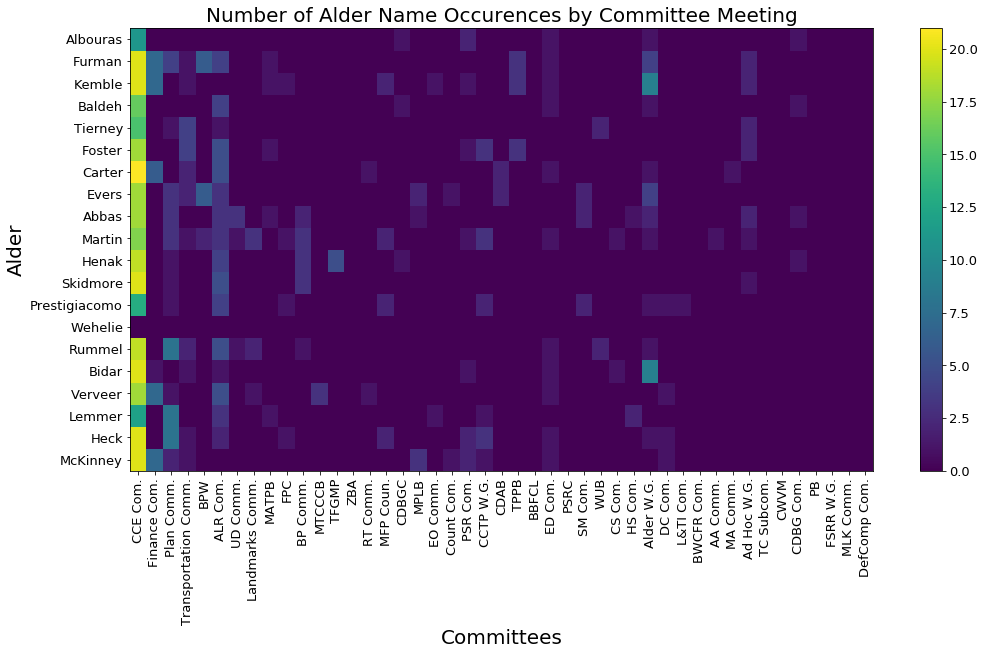

In [138]:
fig, ax = plt.subplots(figsize=(15,9))

plt.pcolor(map_df)
plt.yticks(np.arange(0.5, len(map_df.index), 1), map_df.index)
plt.xticks(np.arange(0.5, len(map_df.columns), 1), map_df.columns)
# ax.xaxis.tick_top()
plt.xticks(rotation=90)
plt.colorbar() 
ax.set_ylabel('Alder',size=20)
ax.set_xlabel('Committees',size=20)
plt.tight_layout()
ax.set_title('Number of Alder Name Occurences by Committee Meeting', size=20)


plt.savefig('alder_occurence.pdf',bbox_inches='tight')

In [131]:
sorted_df= DataFrame({'Average Participants by Meeting':meeting.groupby(by='Abbreviations').mean()['Participants'],
           'Total Number of Alder Mentions':map_df.sum()}).sort_values(by='Average Participants by Meeting', ascending=False)
reset_df = sorted_df.reset_index()

In [132]:
reset_df

,index,Average Participants by Meeting,Total Number of Alder Mentions
0,MPLB,170.000000,6
1,UD Comm.,149.250000,5
2,Plan Comm.,123.666667,44
3,CCE Com.,72.904762,335
4,TFGMP,72.800000,5
5,SM Com.,72.500000,6
6,BP Comm.,71.000000,12
7,ALR Com.,70.666667,57
8,Landmarks Comm.,67.666667,6
9,PB,60.000000,0


Text(0.5, 1.0, 'Participation vs. Alder Mentions')

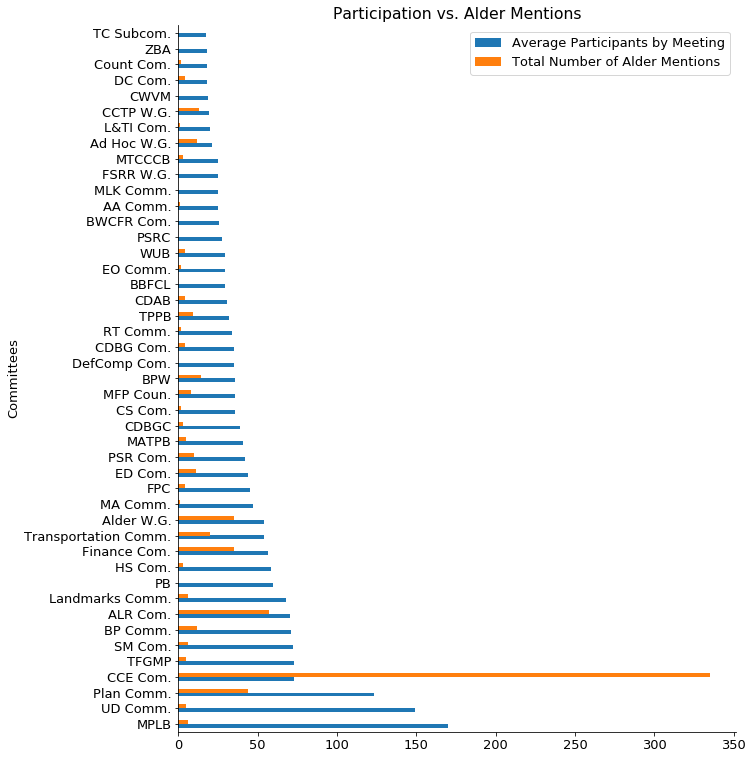

In [133]:
fig, ax = plt.subplots(figsize=(10,13))
sorted_df.plot.barh(ax=ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Committees')
ax.set_title('Participation vs. Alder Mentions')
# plt.savefig('alder_vs_Participation.pdf',bbox_inches='tight')

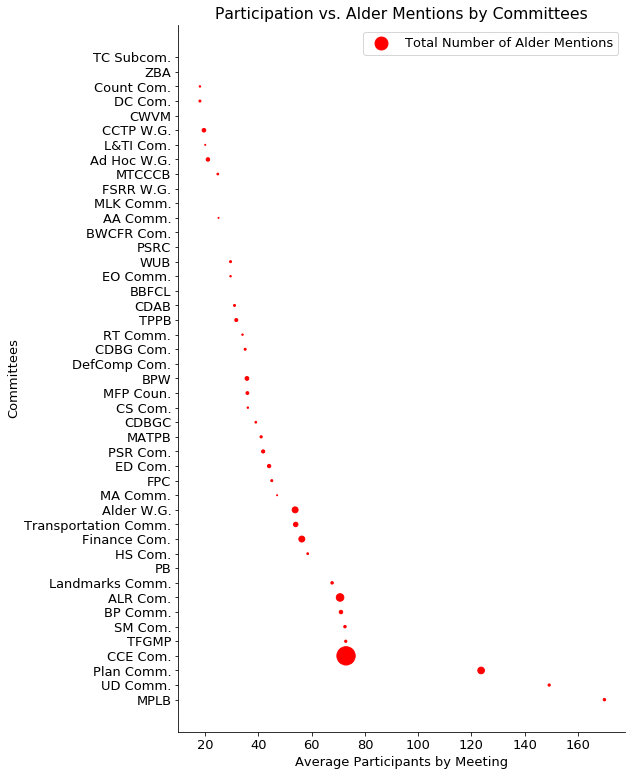

In [134]:
fig, ax = plt.subplots(figsize=(8,13))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.scatter(x=reset_df['Average Participants by Meeting'],y=reset_df['index'],s=reset_df['Total Number of Alder Mentions'], color='red',label='Total Number of Alder Mentions')
# ax.set_ylim(0,)
# ax.set_xlim(0,)
ax.set_title('Alder Mentions by Committee vs. Average Participants')
ax.set_ylabel('Committees')
ax.set_xlabel('Average Participants by Meeting')
ax.set_title('Participation vs. Alder Mentions by Committees')
plt.legend()
plt.savefig('alder_vs_Participation.pdf',bbox_inches='tight')

In [193]:

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/Terry/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [27]:
import nltk
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize

In [23]:
test = meeting['note_text'][0]

In [24]:
alder_list = re.findall(r"[^.]* Ald. [^.]*\.",test)

In [26]:
tokens=nltk.word_tokenize(alder_list[0])
nltk.pos_tag(tokens)

[('ly/345BbJxCALL', 'NN'),
 ('TO', 'NNP'),
 ('ORDER', 'NNP'),
 ('/', 'NNP'),
 ('ROLL', 'NNP'),
 ('CALLShiva', 'NNP'),
 ('Bidar', 'NNP'),
 (';', ':'),
 ('Barbara', 'NNP'),
 ('Harrington-McKinney', 'NNP'),
 (';', ':'),
 ('Arvina', 'NNP'),
 ('Martin', 'NNP'),
 (';', ':'),
 ('Rebecca', 'NNP'),
 ('Kemble', 'NNP'),
 (';', ':'),
 ('Tag', 'NNP'),
 ('Evers', 'NNPS'),
 (';', ':'),
 ('Sheri', 'NNP'),
 ('Carter', 'NNP'),
 (';', ':'),
 ('Grant', 'NNP'),
 ('Foster', 'NNP'),
 ('and', 'CC'),
 ('Samba', 'NNP'),
 ('BaldehPresent:8', 'NNP'),
 ('-', ':'),
 ('Others', 'NNS'),
 ('Attending', 'VBG'),
 (':', ':'),
 ('Mayor', 'NN'),
 ('Satya', 'NNP'),
 ('Rhodes-Conway', 'NNP'),
 (',', ','),
 ('Interim', 'NNP'),
 ('MPD', 'NNP'),
 ('Chief', 'NNP'),
 ('Vic', 'NNP'),
 ('Wahl', 'NNP'),
 (',', ','),
 ('Deputy', 'NNP'),
 ('Mayor', 'NNP'),
 ('Cam', 'NNP'),
 ('McLayAPPROVAL', 'NNP'),
 ('OF', 'NNP'),
 ('MINUTESA', 'NNP'),
 ('motion', 'NN'),
 ('was', 'VBD'),
 ('made', 'VBN'),
 ('by', 'IN'),
 ('Ald', 'NNP'),
 ('.', '.'),


In [30]:
tokenized_text=sent_tokenize(test)
for i in tokenized_text:
    print(i + '\n')

City of MadisonMadison, WI  53703www.cityofmadison.comCity of MadisonMeeting Minutes - ApprovedCOMMON COUNCIL EXECUTIVE COMMITTEE4:30 PMVia Virtual MeetingTuesday, March 31, 2020Meeting Video Available Online at Madison City Channel: https://bit.ly/345BbJxCALL TO ORDER / ROLL CALLShiva Bidar; Barbara Harrington-McKinney; Arvina Martin; Rebecca Kemble; Tag Evers; Sheri Carter; Grant Foster and Samba BaldehPresent:8 - Others Attending: Mayor Satya Rhodes-Conway,  Interim MPD Chief Vic Wahl, Deputy Mayor Cam McLayAPPROVAL OF MINUTESA motion was made by Ald.

Rebecca Kemble, seconded by Ald.

Barbara Harrington-McKinney, to approve the minutes from the March 17, 2020 Common Council Executive Committee meeting.

The motion passed by voice vote/other.PUBLIC COMMENTThere was no public comment.DISCLOSURES AND RECUSALSThere were no disclosures or recusals from the members present.REFERRALS FROM THE COMMON COUNCIL59845Establishing a Body-Worn Camera Feasibility Review Committee as recommended by

In [100]:
print(meeting.sort_values(by='Participants', ascending=False).head(5)['agenda_num'][1])

Commerating the 50th anniversary of Earth Day on April 22, 2020.
Proclaiming the week of April 26 through May 2, 2020 as Arbor Week in the City 
of Madison.
Petition received in the Madison City Clerk's Office 3/6/2020 from Randall A. 
Theis Trust, regarding attachment from the Town of Middleton to the City of 
Madison.
Petition received in the Madison City Clerk's Office 3/10/2020 from Edison LLC, 
regarding attachment from the Town of Middleton to the City of Madison.
Creating Section 28.022 - 00418 of the Madison General Ordinances to amend 
a Planned Development District at property located at 7050 Watts Road, 1st 
Aldermanic District, to approve an Amended General Development Plan.
Creating Section 28.022 -- 00419 of the Madison General Ordinances to change 
the zoning of property located at 935 West Johnson Street, 8th Aldermanic 
District, from TR-U2 Traditional Residential - Urban District 2) District to CI 
(Campus Institutional) District.
Creating Section 28.022 - 00431 of th